In [1]:
import pandas as pd
from scipy.special import expit
from sklearn.metrics import roc_auc_score, average_precision_score

import sys
sys.path.append('../recipes/')
from utils import get_infer_report, get_metrics

import multiprocess as mp
import os

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt


In [2]:
sys.path.append('../scripts/')

from main_from_csv import run_softmax

def print_scores(df_ourmodel_mcpas):
    print("roc_auc_score",roc_auc_score(y_true=df_ourmodel_mcpas.ytrue, 
              y_score=df_ourmodel_mcpas.ypred), )

    print("average_precision_score",average_precision_score(y_true=df_ourmodel_mcpas.ytrue, 
              y_score=df_ourmodel_mcpas.ypred))
    

yymmddhhmmss 20231027_220648


# McPAS

In [3]:
# ours_mcpas = pd.read_parquet("/media/kyohei/forAI/tcrpred/hhyylog/20230627_111332_k-1_datasettest.parquet")
# ours_vdjdb_no10x = pd.read_parquet("/media/kyohei/forAI/tcrpred/hhyylog/20230627_110913_k-1_datasettest.parquet")

# df_ours_mcpas = add_tcrspep(ours_mcpas)
# df_ours_vdjdb_no10x = add_tcrspep(ours_vdjdb_no10x)


In [4]:
df_ourmodel_mcpas = pd.read_parquet("../data/20230627_111332_k-1_datasettest.parquet")
df_ourmodel_mcpas = run_softmax(df_ourmodel_mcpas)
df_ourmodel_vdjdb_no10x_test = pd.read_parquet("../data/20230627_110913_k-1_datasettest.parquet")
df_ourmodel_vdjdb_no10x_test = run_softmax(df_ourmodel_vdjdb_no10x_test)

In [5]:
print_scores(df_ourmodel_mcpas)

roc_auc_score 0.91542032954589
average_precision_score 0.6210691248216531


## Score by peptide type (in-train, not-in-train)

In [6]:
p_list = [f"../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
        f"../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
          f"../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",]

df_mcpas_test = pd.read_parquet("../data/mcpas_test.parquet")

df_mcpas_test['y_true'] = df_ourmodel_mcpas['ytrue'].values
df_mcpas_test['y_pred'] = df_ourmodel_mcpas['ypred'].values

df_mcpas_train = pd.DataFrame(pd.read_pickle(p_list[1])).query('tcra!="UNK"') #.query('sign==1')

## Count overlapping

In [7]:
def add_combinations(df):
    df['tcr_combined'] = df['tcra'] + ":" + df['tcrb']
    df['tcr_pep_combined'] = df['tcra'] + ":" + df['tcrb'] + ":" + df['peptide']
    return df


In [8]:
### overlap Peptides
print("### overlap Peptides")

df_mcpas_test = add_combinations(df_mcpas_test) #['tcr_combined'] = df_mcpas_test['tcra'] + ":" + df_mcpas_test['tcrb']
df_mcpas_train = add_combinations(df_mcpas_train)
df_mcpas_test = df_mcpas_test[~df_mcpas_test.tcr_pep_combined.isin(df_mcpas_train.tcr_pep_combined)]

print("Unique peptide in train", df_mcpas_train.peptide.nunique())
print("Unique peptide in test", df_mcpas_test.peptide.nunique())

print(df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts())

num_ow_pep = df_mcpas_test.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts().loc[True]
print()
print(f"There are {num_ow_pep} overlap peptide between training and test")



### overlap TCRs
print("\n\n")
print("### overlap TCRs")

print("Unique tcr_combined in train", df_mcpas_train.tcr_combined.nunique())
print("Unique tcr_combined in test", df_mcpas_test.tcr_combined.nunique())

print(df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts())

num_ow_tcrs = df_mcpas_test.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts().loc[True]
print()
print(f"There are {num_ow_tcrs} overlap tcrs between training and test")



### overlap Peptides
Unique peptide in train 316
Unique peptide in test 190
True     171
False     19
Name: peptide, dtype: int64

There are 171 overlap peptide between training and test



### overlap TCRs
Unique tcr_combined in train 3181
Unique tcr_combined in test 833
False    701
True     132
Name: tcr_combined, dtype: int64

There are 132 overlap tcrs between training and test


In [9]:
df_mcpas_train.peptide.nunique(), df_mcpas_test.peptide.nunique()

(316, 190)

In [10]:
df_mcpas_test.peptide.isin(df_mcpas_train.peptide).value_counts()

True     4683
False      46
Name: peptide, dtype: int64

In [11]:
df_valid_not_in_train = df_mcpas_test[~df_mcpas_test.peptide.isin(df_mcpas_train.peptide)]
df_valid_in_train = df_mcpas_test[df_mcpas_test.peptide.isin(df_mcpas_train.peptide)]

In [12]:
print('unique peptide count pep in-train', df_valid_in_train.peptide.nunique())
print('unique peptide count pep not-in-train', df_valid_not_in_train.peptide.nunique())
print('interaction count pep in-train', df_valid_in_train.shape[0])
print('interaction count pep not-in-train', df_valid_not_in_train.shape[0])

unique peptide count pep in-train 171
unique peptide count pep not-in-train 19
interaction count pep in-train 4683
interaction count pep not-in-train 46


In [13]:
df_mcpas_test.peptide.value_counts().head(10)

LPRRSGAAGA    569
GILGFVFTL     474
GLCTLVAML     288
SSYRRPVGI     277
NLVPMVATV     227
SSLENFRAYV    192
ASNENMETM     150
CRVLCCYVL     150
LLWNGPMAV     122
HGIRNASFI     119
Name: peptide, dtype: int64

negative_positive_ratio = {0: 32, 1: 14}
- acc 0.6956521739130435
- balanced_acc 0.640625
- precision on 1:  0.5
- precision on 0:  0.78125
- confusion matrix tn, fp, fn, tp: 25, 7, 7, 7
- roc_auc_score 0.7321428571428572
- pr_auc_score on 1 0.5370398235703564
- pr_auc_score on 0 0.8839322338908714


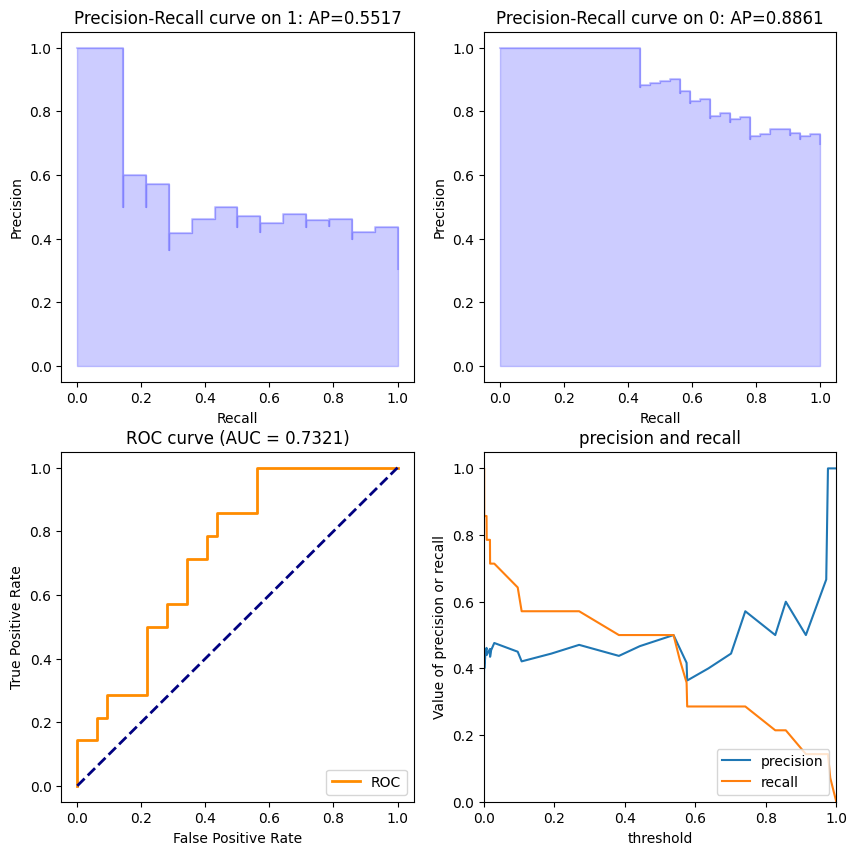

****************************************************************************************************
0    3982
1     701
Name: y_true, dtype: int64
- acc 0.8633354687166347
- balanced_acc 0.8326585182536822
- precision on 1:  0.5291866028708134
- precision on 0:  0.9593183067619572
- confusion matrix tn, fp, fn, tp: 3490, 492, 148, 553
- roc_auc_score 0.9170283751919301
- pr_auc_score on 1 0.6224350105185458
- pr_auc_score on 0 0.9840440729706313


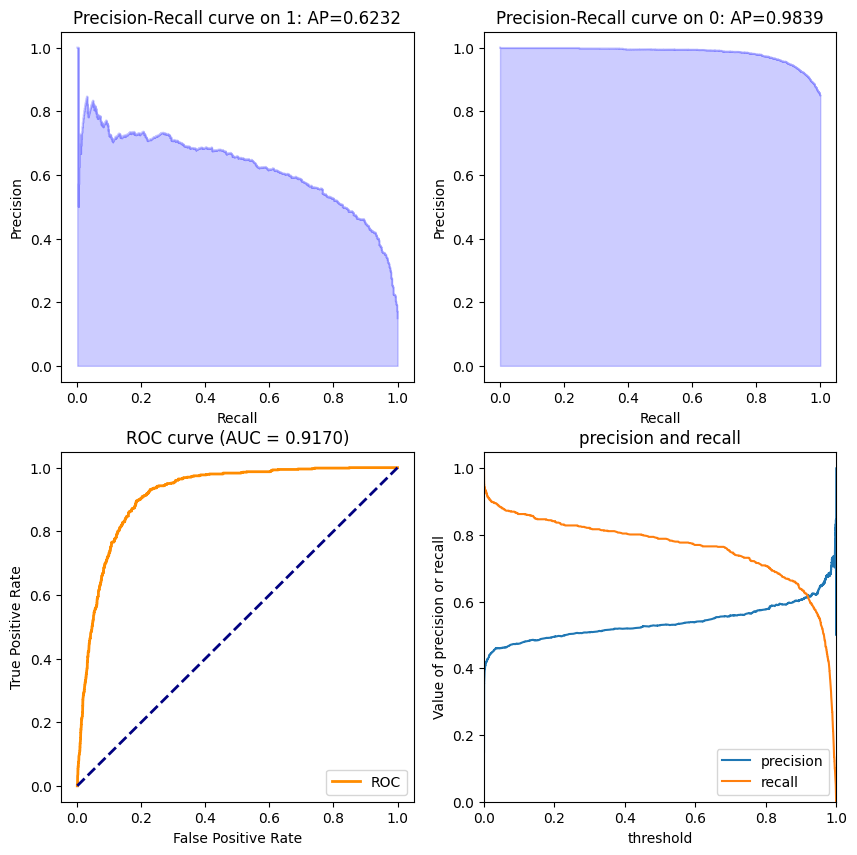

In [14]:

print("negative_positive_ratio =", df_valid_not_in_train.y_true.value_counts().to_dict())

get_infer_report(df_valid_not_in_train.y_true, df_valid_not_in_train.y_pred)

print('*'*100)
print(df_valid_in_train.y_true.value_counts())
get_infer_report(df_valid_in_train.y_true, df_valid_in_train.y_pred)

In [15]:
THH = 0.5
print(sum(df_valid_not_in_train.y_pred>THH))
df_valid_not_in_train[(df_valid_not_in_train.y_true==1) & (df_valid_not_in_train.y_pred>THH)]

14


,tcra,tcrb,peptide,sign,y_true,y_pred,tcr_combined,tcr_pep_combined
4516,CAVKGEGGGADGLTF,CASNLQRAVNTEAF,PGISSQHFTYQGGVGGSWPVCSGLG,1,1,0.976377,CAVKGEGGGADGLTF:CASNLQRAVNTEAF,CAVKGEGGGADGLTF:CASNLQRAVNTEAF:PGISSQHFTYQGGVG...
6927,CAENKDDYKLSF,CASSFSATGELFF,KLSHQPVLL,1,1,0.856724,CAENKDDYKLSF:CASSFSATGELFF,CAENKDDYKLSF:CASSFSATGELFF:KLSHQPVLL
7296,CAASTGGGNKLTF,CSAREGAGGMGTQYF,MTEYKLVVVGADGVGKSALTIQLI,1,1,0.575105,CAASTGGGNKLTF:CSAREGAGGMGTQYF,CAASTGGGNKLTF:CSAREGAGGMGTQYF:MTEYKLVVVGADGVGK...
9474,CAFTSGNQFYF,CATQWTGGHEQYF,RLHDLVLPL,1,1,0.555075,CAFTSGNQFYF:CATQWTGGHEQYF,CAFTSGNQFYF:CATQWTGGHEQYF:RLHDLVLPL
12607,CAVRDQSNQFYF,CSVRVGTQYF,FSSEVLNLV,1,1,0.538035,CAVRDQSNQFYF:CSVRVGTQYF,CAVRDQSNQFYF:CSVRVGTQYF:FSSEVLNLV
13826,CAISMDTGRRALTF,CASSEMDGSNQPQHF,FIMGISILL,1,1,0.982930,CAISMDTGRRALTF:CASSEMDGSNQPQHF,CAISMDTGRRALTF:CASSEMDGSNQPQHF:FIMGISILL
17059,CAYRSALWGAQKLVF,CASSLAENSGNTIYF,FLWSVFMLI,1,1,0.741745,CAYRSALWGAQKLVF:CASSLAENSGNTIYF,CAYRSALWGAQKLVF:CASSLAENSGNTIYF:FLWSVFMLI


## Score by each peptide

In [16]:
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd

# assuming df_mcpas_test is your DataFrame and it has columns 'peptide', 'y_true', 'y_pred'
def show_score_by_each_peptide(df_mcpas_test):
    metrics = []
    for pep in df_mcpas_test.peptide.value_counts().index:
        group = df_mcpas_test.query(f'peptide=="{pep}"')

        if (group['y_true'].mean()==0) or (group['y_true'].mean()==1.0):
            roc_auc = None
            avg_precision = None
        else:
            roc_auc = roc_auc_score(group['y_true'], group['y_pred'])
            avg_precision = average_precision_score(group['y_true'], group['y_pred'])

        positive_rate = group['y_true'].mean()  # assuming y_true is binary (0 or 1)
        number_of_peptide = group.shape[0]

        metrics.append({
            'peptide': pep,
            'average_precision': avg_precision,
            'roc_auc': roc_auc,
            'positive_rate': positive_rate,
            '#_of_peptide(#_of_interactions)': number_of_peptide
        })

    metrics_df_mcpas_test = pd.DataFrame(metrics)
    display(metrics_df_mcpas_test.head(10))
    
    return metrics_df_mcpas_test.head(10)


In [17]:
a = show_score_by_each_peptide(df_mcpas_test)


,peptide,average_precision,roc_auc,positive_rate,#_of_peptide(#_of_interactions)
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.480617,0.829982,0.200422,474
2,GLCTLVAML,0.552719,0.870671,0.065972,288
3,SSYRRPVGI,0.756788,0.875574,0.368231,277
4,NLVPMVATV,0.483179,0.809763,0.123348,227
5,SSLENFRAYV,0.822051,0.899591,0.343750,192
6,ASNENMETM,0.646305,0.849193,0.233333,150
7,CRVLCCYVL,NaN,NaN,0.000000,150
8,LLWNGPMAV,0.745194,0.852906,0.336066,122
9,HGIRNASFI,0.730893,0.894250,0.319328,119


In [18]:
print(a.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &     peptide &  average\_precision &   roc\_auc &  positive\_rate &  \#\_of\_peptide(\#\_of\_interactions) \\
\midrule
0 &  LPRRSGAAGA &                NaN &       NaN &       0.000000 &                              569 \\
1 &   GILGFVFTL &           0.480617 &  0.829982 &       0.200422 &                              474 \\
2 &   GLCTLVAML &           0.552719 &  0.870671 &       0.065972 &                              288 \\
3 &   SSYRRPVGI &           0.756788 &  0.875574 &       0.368231 &                              277 \\
4 &   NLVPMVATV &           0.483179 &  0.809763 &       0.123348 &                              227 \\
5 &  SSLENFRAYV &           0.822051 &  0.899591 &       0.343750 &                              192 \\
6 &   ASNENMETM &           0.646305 &  0.849193 &       0.233333 &                              150 \\
7 &   CRVLCCYVL &                NaN &       NaN &       0.000000 &                              150 \\
8 &   LLWNGP

##  Performance degregation by seq-distance


```
Clustal Omega generates a pairwise distance matrix as a part of its multiple sequence alignment process. This distance matrix measures sequence divergence and is typically based on sequence identity - not Euclidean distance or edit distance.

Sequence identity is the measure of the proportion of nucleotides or amino acids that are identical when two sequences are aligned. The more similar two sequences are, the smaller their distance in the matrix. Clustal Omega computes these distances by estimating the number of substitutions per site between each pair of sequences.

In more technical terms, this distance matrix uses evolutionary distances, estimated by the Jukes-Cantor or Kimura correction models, which take into account the possibility of multiple substitutions at the same site and different substitution rates at different sites.

The distance matrix produced by Clustal Omega serves as the input to guide the hierarchical clustering (using the neighbor-joining or UPGMA method) to build a guide tree. This tree is then used to guide the progressive alignment of the sequences.
```

In [19]:
## 2022-1225_TCR_vs_testset-UMAP-Clustalo-p100.ipynb

In [20]:
def make_distance_mat(traindf, testdf, file_prefix):
    import multiprocess as mp
    import os
    
    df_tcrsall = pd.concat([traindf, testdf])
    df_tcrsall = df_tcrsall.drop_duplicates(subset="tcr_combined")
    df_tcrsall['tcraXtcrb'] = [s.replace(":", "P"*100) for s in df_tcrsall.tcr_combined]
    sequences = df_tcrsall.tcr_combined.values.tolist()

    ofile = open(f"{file_prefix}_fasta.txt", "w")
    for i, seq in enumerate(df_tcrsall.tcraXtcrb.tolist()):
        ofile.write(">" + str(i) + "\n" + seq + "\n")
    ofile.close()

    if not os.path.exists(f"{file_prefix}_aligned.txt"):
        os.system(f"~/Downloads/clustalo -i {file_prefix}_fasta.txt -o {file_prefix}_aligned.txt --full --distmat-out={file_prefix}_distmat.txt")

    if not os.path.exists(f"{file_prefix}_distmat.parquet"):
        pd_reader = pd.read_csv(f'{file_prefix}_distmat.txt',sep=' 0', skiprows=[0], header=None, 
                                      chunksize=1000)

        with mp.Pool(os.cpu_count()-1) as p:
            df_list = p.map(lambda x:x, pd_reader)

        df_distmat = pd.concat(df_list)
        df_distmat = df_distmat.iloc[:,1:]
        df_distmat.columns = df_distmat.columns.astype(str)
        df_distmat.to_parquet(f"{file_prefix}_distmat.parquet")
    else:
        df_distmat = pd.read_parquet(f'{file_prefix}_distmat.parquet')

    df_distmat.index = sequences
    df_distmat.columns = sequences
    return df_distmat
    

## Calculation

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score

def show_pep_fig(df_mcpas_test, peptide, DICT_distance_testtcrs_to_traintcrs, ax, 
                 distance_min=0.55, distance_max=0.61, ):
    group = df_mcpas_test.query(f'peptide=="{peptide}"')
    group['distance_to_train'] = group['tcr_combined'].map(DICT_distance_testtcrs_to_traintcrs)
    dddlist = np.linspace(distance_min, distance_max, 100)
    metrics = []
    
    for ddd in dddlist:
        dfg = group[group['distance_to_train']>ddd]

        if (dfg['y_true'].mean()==0) or (dfg['y_true'].mean()==1.0) or len(dfg)==0:
            roc_auc = None
            avg_precision = None
            positive_rate = None
        else:
            roc_auc = roc_auc_score(dfg['y_true'], dfg['y_pred'])
            avg_precision = average_precision_score(dfg['y_true'], dfg['y_pred'])
            positive_rate = dfg['y_true'].mean()  # assuming y_true is binary (0 or 1)

        number_of_interactions = dfg.shape[0]
        metrics.append({
            'average_precision': avg_precision,
            'roc_auc': roc_auc,
            'positive_rate': positive_rate,
            'number_of_interactions': number_of_interactions
        })
    metrics_df_mcpas_test = pd.DataFrame(metrics)
    metrics_df_mcpas_test.index = dddlist
    metrics_df_mcpas_test.plot(
                    title=peptide, 
                    secondary_y='number_of_interactions',
                    ylim=(0,1.0),
                    xlabel="distance_to_train", ax=ax, #fontsize=fontsize
    )

    
    

def show_Performance_degregation(df_mcpas_test, peplist, DICT_distance_testtcrs_to_traintcrs):
    
    fig, axs = plt.subplots(len(peplist), 1, figsize=(10, 2*len(peplist)))
    
    if len(peplist)==1:
        show_pep_fig(df_mcpas_test, peplist[0], DICT_distance_testtcrs_to_traintcrs, axs)
    else:
        for i, pep in enumerate(peplist):
            show_pep_fig(df_mcpas_test, pep, DICT_distance_testtcrs_to_traintcrs, axs[i])


In [22]:
df_distmat = make_distance_mat(df_mcpas_train, df_mcpas_test,  "mcpas")
# df_distmat.index = sequences
# df_distmat.columns = sequences

_temp = df_distmat[df_distmat.index.isin(df_mcpas_test.tcr_combined)]
_temp = _temp[df_mcpas_train.tcr_combined.unique()]
DICT_distance_testtcrs_to_traintcrs_mcpas = _temp.min(axis=1).to_dict()


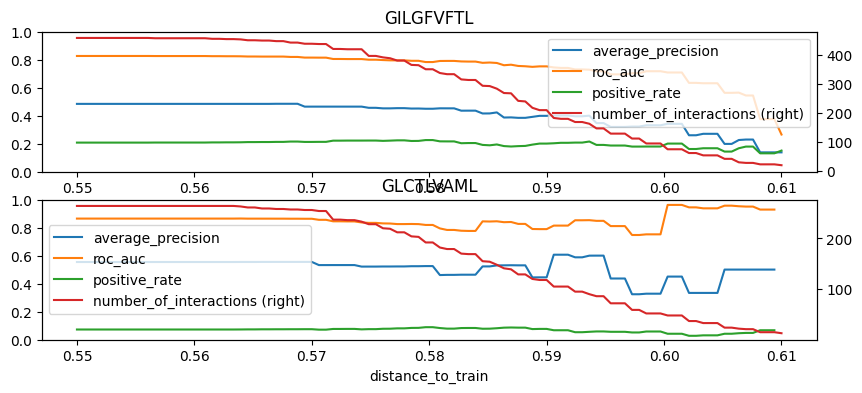

In [23]:
# peplist = ['GILGFVFTL', 'GLCTLVAML', 'SSYRRPVGI', 'NLVPMVATV', 'ELAGIGILTV']
peplist = ['GILGFVFTL', 'GLCTLVAML', ]

show_Performance_degregation(df_mcpas_test, peplist, DICT_distance_testtcrs_to_traintcrs_mcpas)

In [24]:
dlist = []
for pep in df_mcpas_test.peptide.unique():
    dfg = df_mcpas_test.query(f'peptide=="{pep}"')    
    
    if (dfg['y_true'].mean()==0) or (dfg['y_true'].mean()==1.0) or len(dfg)==0:
        roc_auc = None
        avg_precision = None
        positive_rate = None
    else:
        roc_auc = roc_auc_score(dfg['y_true'], dfg['y_pred'])
        avg_precision = average_precision_score(dfg['y_true'], dfg['y_pred'])
        positive_rate = dfg['y_true'].mean()  # assuming y_true is binary (0 or 1)
    
    
    dlist.append((len(dfg), avg_precision, roc_auc))
    
dlist = pd.DataFrame(dlist)
dlist.index = df_mcpas_test.peptide.unique()
dlist.columns = ['count', 'avg_precision', 'rocauc']
# stopstop

<Axes: xlabel='[log_count]', ylabel='[rocauc]'>

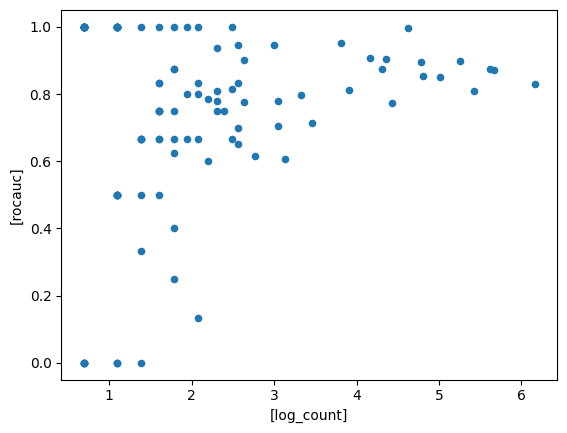

In [25]:
dlist['log_count'] = dlist['count'].apply(np.log)
dlist.dropna().plot.scatter(x=['log_count'], y=['rocauc'])

<Axes: xlabel='[log_count]', ylabel='[avg_precision]'>

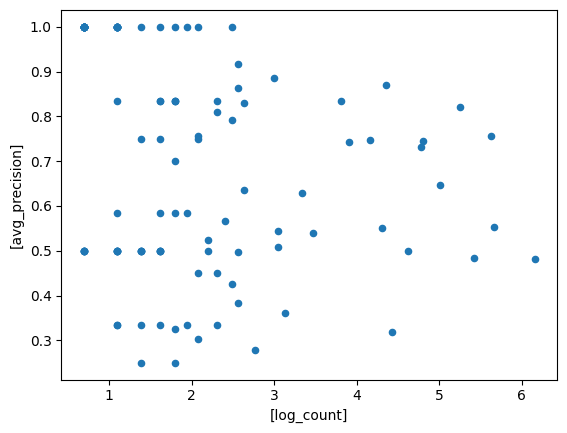

In [26]:
dlist.dropna().plot.scatter(x=['log_count'], y=['avg_precision'])

In [27]:
pd.DataFrame(dlist)

,count,avg_precision,rocauc,log_count
SSLENFRAYV,192,0.822051,0.899591,5.257495
EAAGIGILTV,74,0.550000,0.875000,4.304065
LPRRSGAAGA,569,NaN,NaN,6.343880
ASNENMETM,150,0.646305,0.849193,5.010635
SSYRRPVGI,277,0.756788,0.875574,5.624018
...,...,...,...,...
RLVPYLEFL,2,0.500000,0.000000,0.693147
FLKEKGGL,2,NaN,NaN,0.693147
LLSIISFPA,1,NaN,NaN,0.000000
SLLLLPVSV,1,NaN,NaN,0.000000


# VDJDB

In [28]:
# !mv ../../hhyylog/20210911_043036_k0_hh.csv ../../hhyylog/20210911_043036_k0_test_hh.csv 
# !mv ../../hhyylog/20210911_043036_k0_yy.csv ../../hhyylog/20210911_043036_k0_test_yy.csv 

In [29]:
p_list = [
    f"../../external_data/ERGO-II/Samples/vdjdb_no10x_train_samples.pickle",
    f"../../external_data/ERGO-II/Samples/vdjdb_no10x_test_samples.pickle",
         ]

df_vdjdb_no10x_test = pd.read_parquet("./../data/vdjdb_no10x_test.parquet")
df_vdjdb_no10x_train = pd.DataFrame(pd.read_pickle(p_list[0])).query('tcra!="UNK"') #.query('sign==1')

df_vdjdb_no10x_test['y_pred'] = df_ourmodel_vdjdb_no10x_test.ypred.values
df_vdjdb_no10x_test['y_true'] = df_ourmodel_vdjdb_no10x_test.ytrue.values


### overlap Peptides
print("### overlap Peptides")

df_vdjdb_no10x_test = add_combinations(df_vdjdb_no10x_test)
df_vdjdb_no10x_train = add_combinations(df_vdjdb_no10x_train)
df_vdjdb_no10x_test = df_vdjdb_no10x_test[~df_vdjdb_no10x_test.tcr_pep_combined.isin(df_vdjdb_no10x_train.tcr_pep_combined)]

print("Unique peptide in train", df_vdjdb_no10x_train.peptide.nunique())
print("Unique peptide in test", df_vdjdb_no10x_test.peptide.nunique())

print(df_vdjdb_no10x_test.peptide.drop_duplicates().isin(df_vdjdb_no10x_train.peptide).value_counts())

num_ow_pep = df_vdjdb_no10x_test.peptide.drop_duplicates().isin(df_vdjdb_no10x_train.peptide).value_counts().loc[True]
print()
print(f"There are {num_ow_pep} overlap peptide between training and test")



### overlap TCRs
print("\n\n")
print("### overlap TCRs")

print("Unique tcr_combined in train", df_vdjdb_no10x_train.tcr_combined.nunique())
print("Unique tcr_combined in test", df_vdjdb_no10x_test.tcr_combined.nunique())

print(df_vdjdb_no10x_test.tcr_combined.drop_duplicates().isin(df_vdjdb_no10x_train.tcr_combined).value_counts())

num_ow_tcrs = df_vdjdb_no10x_test.tcr_combined.drop_duplicates().isin(df_vdjdb_no10x_train.tcr_combined).value_counts().loc[True]
print()
print(f"There are {num_ow_tcrs} overlap tcrs between training and test")



### overlap Peptides
Unique peptide in train 175
Unique peptide in test 119
True     111
False      8
Name: peptide, dtype: int64

There are 111 overlap peptide between training and test



### overlap TCRs
Unique tcr_combined in train 2902
Unique tcr_combined in test 689
False    578
True     111
Name: tcr_combined, dtype: int64

There are 111 overlap tcrs between training and test


In [30]:
print_scores(df_ourmodel_vdjdb_no10x_test)

roc_auc_score 0.9445410653415244
average_precision_score 0.7599751603795519


## Score by each peptide, per peptide

In [31]:
a = show_score_by_each_peptide(df_vdjdb_no10x_test)

print(a.to_latex())

,peptide,average_precision,roc_auc,positive_rate,#_of_peptide(#_of_interactions)
0,NLVPMVATV,0.405348,0.909910,0.043103,696
1,GILGFVFTL,0.437703,0.843267,0.176923,520
2,ELAGIGILTV,0.690000,0.981712,0.019084,262
3,GLCTLVAML,0.724934,0.901736,0.103960,202
4,SSYRRPVGI,0.888556,0.924274,0.481707,164
5,TTPESANL,NaN,NaN,0.000000,148
6,CTPYDINQM,NaN,NaN,0.000000,128
7,SSLENFRAYV,0.877648,0.844697,0.610619,113
8,LLWNGPMAV,0.740981,0.829817,0.453704,108
9,ASNENMETM,0.790623,0.838272,0.454545,99


\begin{tabular}{llrrrr}
\toprule
{} &     peptide &  average\_precision &   roc\_auc &  positive\_rate &  \#\_of\_peptide(\#\_of\_interactions) \\
\midrule
0 &   NLVPMVATV &           0.405348 &  0.909910 &       0.043103 &                              696 \\
1 &   GILGFVFTL &           0.437703 &  0.843267 &       0.176923 &                              520 \\
2 &  ELAGIGILTV &           0.690000 &  0.981712 &       0.019084 &                              262 \\
3 &   GLCTLVAML &           0.724934 &  0.901736 &       0.103960 &                              202 \\
4 &   SSYRRPVGI &           0.888556 &  0.924274 &       0.481707 &                              164 \\
5 &    TTPESANL &                NaN &       NaN &       0.000000 &                              148 \\
6 &   CTPYDINQM &                NaN &       NaN &       0.000000 &                              128 \\
7 &  SSLENFRAYV &           0.877648 &  0.844697 &       0.610619 &                              113 \\
8 &   LLWNGP

In [32]:
df_distmat = make_distance_mat(df_vdjdb_no10x_train, df_vdjdb_no10x_test, "vdjdbno10x")
_temp = df_distmat[df_distmat.index.isin(df_vdjdb_no10x_test.tcr_combined)]
_temp = _temp[df_vdjdb_no10x_train.tcr_combined.unique()]
DICT_distance_testtcrs_to_traintcrs_vdjdb = _temp.min(axis=1).to_dict()


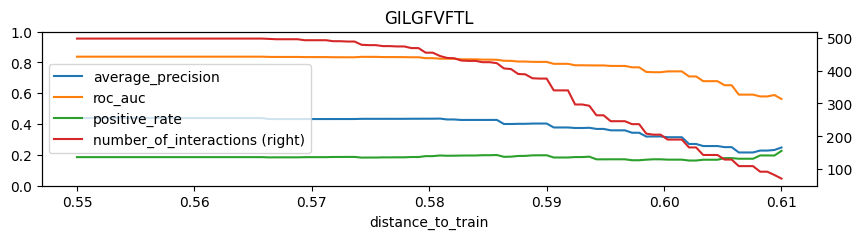

In [33]:
# peplist = ['GILGFVFTL', 'GLCTLVAML', 'SSYRRPVGI', 'NLVPMVATV', 'ELAGIGILTV']
peplist = ['GILGFVFTL']

ax1 = show_Performance_degregation(df_vdjdb_no10x_test, peplist, DICT_distance_testtcrs_to_traintcrs_vdjdb)

In [34]:
pep = 'GILGFVFTL'
min_mcpas = min([DICT_distance_testtcrs_to_traintcrs_mcpas[k] for k in 
    df_mcpas_test.query(f'peptide=="{pep}"').tcr_combined.values
                 if DICT_distance_testtcrs_to_traintcrs_mcpas[k]>0.5
                ])
max_mcpas = max([DICT_distance_testtcrs_to_traintcrs_mcpas[k] for k in 
    df_mcpas_test.query(f'peptide=="{pep}"').tcr_combined.values
                 if DICT_distance_testtcrs_to_traintcrs_mcpas[k]>0.5
                ])

In [35]:
min_vdjdb = min([DICT_distance_testtcrs_to_traintcrs_vdjdb[k] for k in 
                    df_vdjdb_no10x_test.query(f'peptide=="{pep}"').tcr_combined.values 
                 if DICT_distance_testtcrs_to_traintcrs_vdjdb[k]>0.5
                ])
max_vdjdb = max([DICT_distance_testtcrs_to_traintcrs_vdjdb[k] for k in 
                    df_vdjdb_no10x_test.query(f'peptide=="{pep}"').tcr_combined.values
                 if DICT_distance_testtcrs_to_traintcrs_vdjdb[k]>0.5
                ])

In [40]:
def show_pep_fig(df_mcpas_test, peptide, DICT_distance_testtcrs_to_traintcrs, ax, 
                 distance_min=0.55, distance_max=0.61, fontsize=14):
    group = df_mcpas_test.query(f'peptide=="{peptide}"')
    group['distance_to_train'] = group['tcr_combined'].map(DICT_distance_testtcrs_to_traintcrs)
    dddlist = np.linspace(distance_min, distance_max, 100)
    metrics = []
    
    for ddd in dddlist:
        dfg = group[group['distance_to_train']>ddd]

        if (dfg['y_true'].mean()==0) or (dfg['y_true'].mean()==1.0) or len(dfg)==0:
            roc_auc = None
            avg_precision = None
            positive_rate = None
        else:
            roc_auc = roc_auc_score(dfg['y_true'], dfg['y_pred'])
            avg_precision = average_precision_score(dfg['y_true'], dfg['y_pred'])
            positive_rate = dfg['y_true'].mean()  # assuming y_true is binary (0 or 1)

        record_counts = dfg.shape[0]
        metrics.append({
            'average_precision': avg_precision,
            'roc_auc': roc_auc,
            'positive_rate': positive_rate,
            'record_counts': record_counts
        })
    metrics_df_mcpas_test = pd.DataFrame(metrics)
    metrics_df_mcpas_test.index = dddlist
    metrics_df_mcpas_test.plot(
                    title=peptide, 
                    secondary_y='record_counts',
                    ylim=(0,1.0),
                    xlabel="distance_to_train", ax=ax, fontsize=fontsize
    )

    

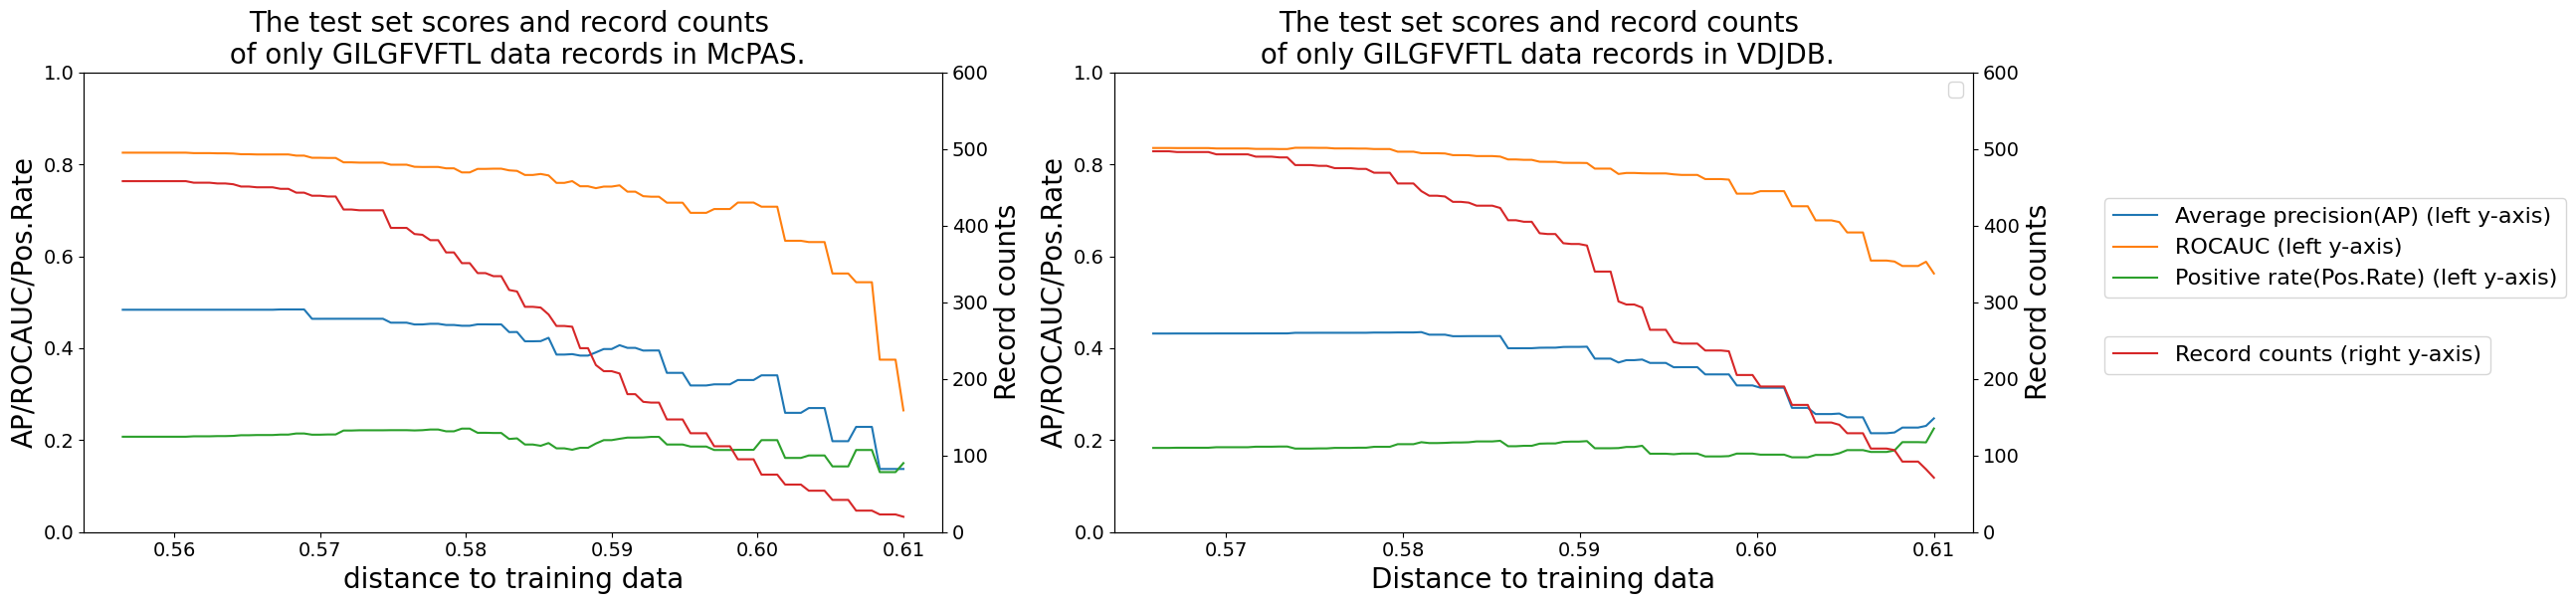

In [68]:
plt.rc('legend', fontsize=14)    # legend fontsize

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24.5, 6))

pep = 'GILGFVFTL'

ax1.set_ylim(0,1.0)
# ax1.set_xticklabels(labels=list(''*len(show1)))

show_pep_fig(df_mcpas_test, pep, DICT_distance_testtcrs_to_traintcrs_mcpas, 
             ax1, 
            min_mcpas+0.0, 0.61 #max_mcpas
            )

ax1.set_title('The test set scores and record counts \n of only GILGFVFTL data records in McPAS.', fontsize=20)
ax1.set_ylim(0,1.0)
ax1.right_ax.set_ylim(0,600)
ax1.right_ax.set_ylabel('Record counts', fontsize=20)
# ax1.right_ax.legend('Record counts')
ax1.set_ylabel('AP/ROCAUC/Pos.Rate', fontsize=20)
ax1.set_xlabel('distance to training data', fontsize=20)

# ax1.legend(fontsize=14,)

show_pep_fig(df_vdjdb_no10x_test, pep, DICT_distance_testtcrs_to_traintcrs_vdjdb, ax2,
             min_vdjdb+0.0, 0.61 #max_vdjdb
            )

ax1.legend(['Average precision(AP) (left y-axis)', 'ROCAUC (left y-axis)','Positive rate(Pos.Rate) (left y-axis)'],
           bbox_to_anchor=(2.34, .75), loc="upper left",
           fontsize=16
          )

ax2.legend("")

ax2.set_title('The test set scores and record counts \n of only GILGFVFTL data records in VDJDB.', fontsize=20)
ax2.set_ylabel('AP/ROCAUC/Pos.Rate', fontsize=20)

ax2.set_ylim(0,1.0)
ax2.right_ax.set_ylim(0,600)
ax2.right_ax.set_ylabel('Record counts', fontsize=20)
ax2.set_xlabel('Distance to training data', fontsize=20)

# ax2.legend(fontsize=14)
plt.legend(["Record counts (right y-axis)"], bbox_to_anchor=(1.14, 0.45), loc="upper left",
           fontsize=16
          )


In [38]:
ax1

<Axes: title={'center': 'MCPAS test set scores and record counts'}, xlabel='distance_to_train'>

In [ ]:
ax1.r

# Were the sequences for which structural analysis was performed absent from the training dataset/ what was the Levenshtein distance of the closest TCR(s) with the same specificity?

In [37]:
df_vdjdb_no10x_test = df_vdjdb_no10x_test.copy()
df_vdjdb_no10x_train = df_vdjdb_no10x_train.copy()

df_vdjdb_no10x_test = add_combinations(df_vdjdb_no10x_test)
df_vdjdb_no10x_train = add_combinations(df_vdjdb_no10x_train)


In [38]:
AACODES = pd.read_csv('./aa_codes.csv')
AACODES['Abbreviation'] = AACODES['Abbreviation'].apply(lambda a: a.upper())
AACODES_DICT = {row['Abbreviation']:row['1 letter abbreviation'] for i, row in AACODES.iterrows()}

d20220211_191954_DICT_PDBID_2_CDRS = pd.read_pickle("./DICT_PDB_Result/20220211_191954_DICT_PDBID_2_CDRS.pickle")

listpdbids = "2VLK", "5WKF", "3PQY", "4MJI", "4P2Q", "2YPL", "1J8H", "4P2R", "5MEN", "3MV8", "4OZF", "3VXR", "3VXS", "4OZG", "5TEZ", "2J8U", "6Q3S", "4JRX", "3VXU", "1U3H", "4JRY", "4Z7V", "4JFE", "4JFD", "3QIU", "2Z31", "2BNR", "3MBE", "4OZH", "2NX5", "5NHT", "4QOK", "5D2L", "1D9K", "4P2O", "5WKH", "6EQB", "2VLR", "6EQA"

def res_to_seq(res):
    return [AACODES_DICT[r.get_resname()] for r in res]

pdb_cdrs = []
for p in d20220211_191954_DICT_PDBID_2_CDRS.keys():
    cdr3tcra,  cdr3tcrb, pep = d20220211_191954_DICT_PDBID_2_CDRS[p]
    cdr3tcra = "".join(res_to_seq(cdr3tcra))
    cdr3tcrb = "".join(res_to_seq(cdr3tcrb))
    pep = "".join(res_to_seq(pep))
    pdb_cdrs.append({"tcra":cdr3tcra, "tcrb":cdr3tcrb, "peptide":pep,
                     "tcr_combined":cdr3tcra+":"+cdr3tcrb, "pdbid":p,
                     "tcr_pep_combined":cdr3tcra+":"+cdr3tcrb+":"+pep
                    })
    
df_pdb_cdrs = pd.DataFrame(pdb_cdrs)


In [39]:
df_pdb_cdrs.to_parquet("../data/pdb_complex_sequences.parquet")

In [40]:
!git add ../data/pdb_complex_sequences.parquet

In [41]:
len(listpdbids)

39

In [42]:
num_ow_pdb_and_seq = df_pdb_cdrs['tcr_combined'].isin(
    df_mcpas_train.tcr_combined.tolist() +\
    df_mcpas_test.tcr_combined.tolist() +\
    df_vdjdb_no10x_train.tcr_combined.tolist() +\
    df_vdjdb_no10x_test.tcr_combined.tolist()
).value_counts().loc[True]

print(f"Within 39 PDB structures, there are {num_ow_pdb_and_seq} overlapped in the training sequences")

Within 39 PDB structures, there are 37 overlapped in the training sequences


In [43]:
num_ow_pdb_and_seq = df_pdb_cdrs['tcr_pep_combined'].isin(
    df_mcpas_train.tcr_pep_combined.tolist() +\
    df_mcpas_test.tcr_pep_combined.tolist() +\
    df_vdjdb_no10x_train.tcr_pep_combined.tolist() +\
    df_vdjdb_no10x_test.tcr_pep_combined.tolist()
).value_counts().loc[True]

print(f"Within 39 PDB structures, there are {num_ow_pdb_and_seq} overlapped in the training sequences")

Within 39 PDB structures, there are 35 overlapped in the training sequences


In [44]:
df_pdb_cdrs['in_sequence_data'] = df_pdb_cdrs['tcr_pep_combined'].isin(
    df_mcpas_train.tcr_pep_combined.tolist() +\
    df_mcpas_test.tcr_pep_combined.tolist() +\
    df_vdjdb_no10x_train.tcr_pep_combined.tolist() +\
    df_vdjdb_no10x_test.tcr_pep_combined.tolist()
)


df_pdb_cdrs[~df_pdb_cdrs['in_sequence_data']].pdbid.tolist()

['1YMM',
 '2ICW',
 '5NQK',
 '3UTS',
 '4GG6',
 '5BRZ',
 '6RPB',
 '1KJ2',
 '6RPA',
 '5E9D',
 '3UTT',
 '5MEN',
 '3D3V',
 '2J8U',
 '3PL6',
 '4Z7U',
 '5WLG',
 '3VXU',
 '2UWE',
 '1LP9',
 '3W0W',
 '6AVF',
 '4JFE',
 '3VXM',
 '4JFD',
 '4P4K',
 '6AVG',
 '5ISZ',
 '5KS9',
 '1QRN',
 '3PWP',
 '4OZI',
 '3D39',
 '1MI5',
 '5NHT',
 '4QOK',
 '3KPS',
 '6EQB',
 '3KPR',
 '6EQA']

In [45]:
df_pdb_cdrs

,tcra,tcrb,peptide,tcr_combined,pdbid,tcr_pep_combined,in_sequence_data
0,CAGAGSQGNLIF,CASSSRSSYEQYF,GILGFVFTL,CAGAGSQGNLIF:CASSSRSSYEQYF,2VLK,CAGAGSQGNLIF:CASSSRSSYEQYF:GILGFVFTL,True
1,CATDTTSGTYKYIF,,ENPVVHFFKNIVTP,CATDTTSGTYKYIF:,1YMM,CATDTTSGTYKYIF::ENPVVHFFKNIVTP,False
2,CAVSGFASALTF,CASGGGGTLYF,PKYVKQNTLKLAT,CAVSGFASALTF:CASGGGGTLYF,2ICW,CAVSGFASALTF:CASGGGGTLYF:PKYVKQNTLKLAT,False
3,CGLGDAGNMLTF,CASSLGQGLLYGYTF,GTSGSPIVNR,CGLGDAGNMLTF:CASSLGQGLLYGYTF,5WKF,CGLGDAGNMLTF:CASSLGQGLLYGYTF:GTSGSPIVNR,True
4,CAGGGGADGLTF,CASSQGLAGAGELFF,EVEQNSGPLSVPEGAIASLNCTYSDRGSQSFFWYRQYSGKSPELIM...,CAGGGGADGLTF:CASSQGLAGAGELFF,5NQK,CAGGGGADGLTF:CASSQGLAGAGELFF:EVEQNSGPLSVPEGAIA...,False
...,...,...,...,...,...,...,...
70,CGLGDAGNMLTF,CASSLGQGLLYGYTF,GTSGSPIINR,CGLGDAGNMLTF:CASSLGQGLLYGYTF,5WKH,CGLGDAGNMLTF:CASSLGQGLLYGYTF:GTSGSPIINR,True
71,CAVNDGGRLTF,CAWSETGLGMGGWQF,AAGIGILTV,CAVNDGGRLTF:CAWSETGLGMGGWQF,6EQB,CAVNDGGRLTF:CAWSETGLGMGGWQF:AAGIGILTV,False
72,,CASSLGQAYEQYF,EEYLKAWTF,:CASSLGQAYEQYF,3KPR,:CASSLGQAYEQYF:EEYLKAWTF,False
73,CAGAGSQGNLIF,CASSSRASYEQYF,GILGFVFTL,CAGAGSQGNLIF:CASSSRASYEQYF,2VLR,CAGAGSQGNLIF:CASSSRASYEQYF:GILGFVFTL,True


# What was the maximum length the TCR sequences were padded to, and how were full sequences imputed if only the V gene and CDR3 sequences are present in some of their training data? 

This key information is either missing from the methods, or not obvious to the reader, with the
methods section stating “TCR sequences” but not defining which part or the entirety. It only becomes obvious in the results section where authors subdivide attention statistics based on inside or outside the CDR regions

In [40]:
df_mcpas = pd.concat([df_mcpas_train,df_mcpas_test])
df_vdjdb = pd.concat([df_vdjdb_no10x_train,df_vdjdb_no10x_test])

In [41]:
print(df_mcpas.tcra.apply(len).max(), df_mcpas.tcra.apply(len).min())

print(df_mcpas.tcrb.apply(len).max(), df_mcpas.tcrb.apply(len).min())

print(df_mcpas.peptide.apply(len).max(), df_mcpas.peptide.apply(len).min())

26 6
21 7
25 8


In [42]:
df_vdjdb.tcra.apply(len).max(), df_vdjdb.tcra.apply(len).min(),\
df_vdjdb.tcrb.apply(len).max(), df_vdjdb.tcrb.apply(len).min(), 


print(df_vdjdb.peptide.apply(len).max(), df_vdjdb.peptide.apply(len).min())

20 8
